## China as a Global Creditor - a Data Exercise

#### 1. China’s International Investment Position 
Visit the website of China’s State Administration of Foreign Exchange (SAFE) and download time series data on China’s International Investment Position.

Data-Source: https://www.safe.gov.cn/en/2018/0329/1412.html


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown


# Import Excel
SAFE_data_raw = pd.read_excel(
    r"C:\Users\jonaw\OneDrive\Dokumente\Coding\Computational Economics"
    r"\Data Viz\China as a Global Creditor - a Data Excercise"
    r"\data\The time-series data of International Investment Position of China.xlsx",
    sheet_name="Annual(USD)",
    header=2
)

# Replace / with NaN
SAFE_data_raw.replace("/", np.nan, inplace=True)
SAFE_data_raw = SAFE_data_raw.infer_objects()

# Create side for Assets and Liabilities
SAFE_data_raw['Side'] = (
    SAFE_data_raw['Item']
      .where(SAFE_data_raw['Item'].isin(['Assets','Liabilities']))
      .ffill()
)


# Drop first row and rows from 50
SAFE_data_raw = SAFE_data_raw.iloc[1:].reset_index(drop=True)
SAFE_data_raw = SAFE_data_raw.iloc[:50].copy()




C:\Users\jonaw\AppData\Local\Temp\ipykernel_29660\2408200753.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  SAFE_data_raw.replace("/", np.nan, inplace=True)


In [81]:
# Transform the data to long format
SAFE_data_long = (
    SAFE_data_raw
      .melt(id_vars=['Side','Item'], var_name='Year', value_name='Value')
      .rename(columns={'Item':'Category'})
)

# Clean up Year: remove “end-” and make it integer
SAFE_data_long["Year"] = (
    SAFE_data_long["Year"]
      .str.replace("end-", "", regex=False)
      .astype(int)
)

# Set value to numeric
SAFE_data_long["Value"] = pd.to_numeric(SAFE_data_long["Value"], errors="coerce")

SAFE_data_long.head()


,Side,Category,Year,Value
0,NaN,Net International Investment Position,2004,2407.831855
1,Assets,Assets,2004,9361.972409
2,Assets,1 Direct investment,2004,596.393975
3,Assets,1.1 Equity and investment fund shares,2004,583.393475
4,Assets,1.2 Debt instruments,2004,13.000500


**Question 1a**. Is China a net creditor or a net debtor towards the rest of the world? How has its net asset position evolved over the past 20 years?

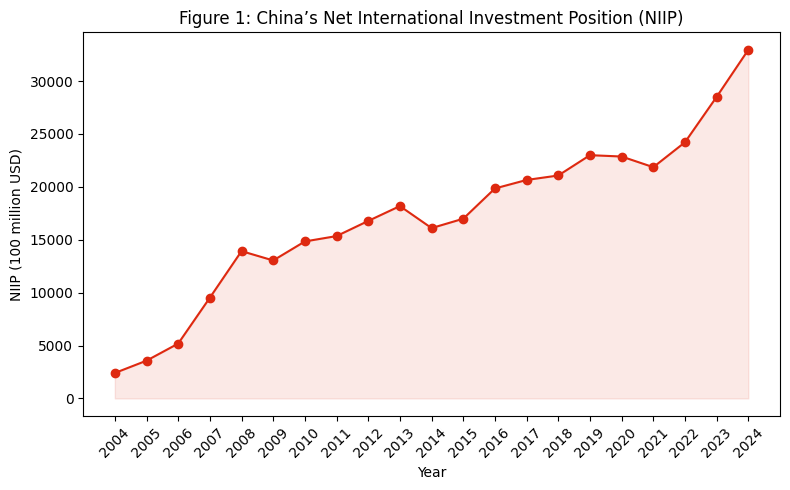

NIIP change (2004-2024):1268.77%


In [82]:
import matplotlib.pyplot as plt
# Define the Net International Investment Position (NIIP) (Assets - Liabilities)
niip = SAFE_data_long[SAFE_data_long["Category"] == "Net International Investment Position"]

plt.figure(figsize=(8,5))
plt.plot(niip.Year, niip.Value, 'o-', color="#DE2910" )

# Set x-ticks
plt.xticks(niip.Year, rotation=45)

# Shade under the line
plt.fill_between(niip.Year,niip.Value,color="#DE2910",alpha=0.1)

plt.title("Figure 1: China’s Net International Investment Position (NIIP)")
plt.xlabel("Year")
plt.ylabel("NIIP (100 million USD)")
plt.tight_layout()
plt.show()

# grab 2004 and 2024
NIIP_2004 = niip.loc[niip.Year == 2004, "Value"].item()
NIIP_2024= niip.loc[niip.Year == 2024, "Value"].item()

NIIP_change  = (NIIP_2024 / NIIP_2004 - 1) * 100
print(f"NIIP change (2004-2024):{NIIP_change:.2f}%")

**Answer 1.a** : Over the last twenty years China has been a net creditor for the rest a the world, as its external assets exceeds its liabilities by far. The NIIP increased by about 1.268% (not inflation-adjusted).

**Question 1b**. Show graphically how the composition of China’s external assets and liabilities looked in 2007 at the onset of the Global Financial Crisis and how it looks today. Explain how China’s investments and liabilities have evolved over time. Which types of assets and liabilities have become more or less important?

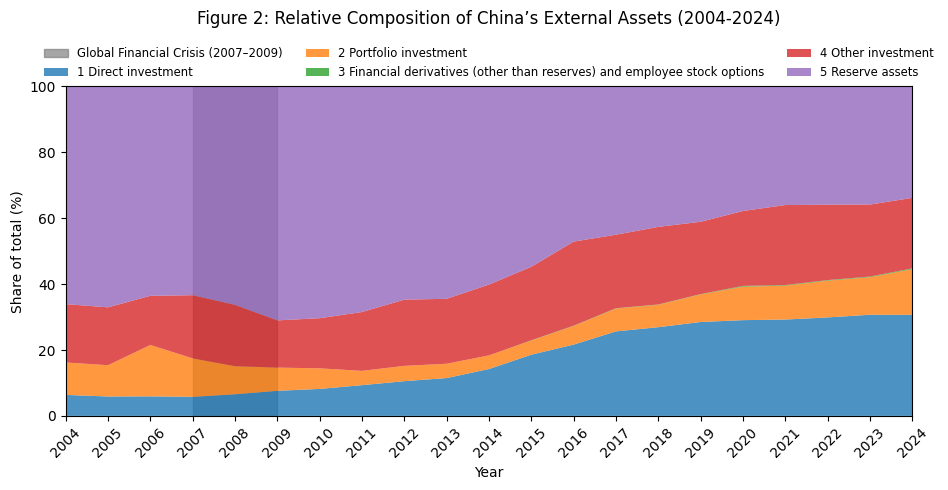

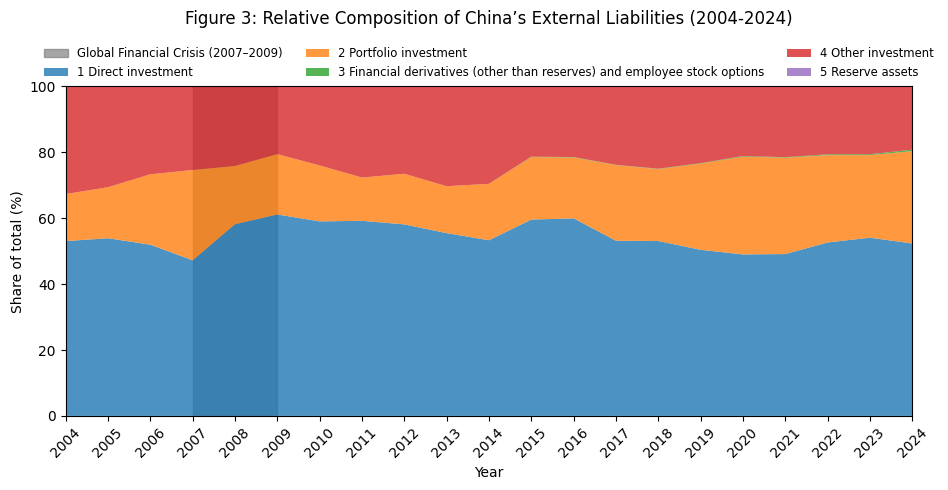

In [83]:

# Clean Category names
SAFE_data_long['Category_clean'] = (
    SAFE_data_long['Category']
      .astype(str) # Convert to string
      .str.strip() # Remove leading/trailing spaces
      .str.replace(' +', '_', regex=True) # Replace spaces with underscores
)

# Define the top balance categories
top5 = [
    "1_Direct_investment",
    "2_Portfolio_investment",
    "3_Financial_derivatives_(other_than_reserves)_and_employee_stock_options",
    "4_Other_investment",
    "5_Reserve_assets"
]

# Filter the data for the top 5 categories and create a new Dataframe
df_top5 = SAFE_data_long[
    SAFE_data_long['Category_clean'].isin(top5)
].copy()

# Pivot to wide format
pivot = df_top5.pivot_table(
    index='Year',
    columns=['Side','Category_clean'],
    values='Value',
    aggfunc='sum'
)

#Compute relative shares (%) for Assets
assets = pivot['Assets'].reindex(columns=top5, fill_value=0)
assets_pct = assets.div(assets.sum(axis=1), axis=0) * 100

#Compute relative shares (%) for Liabilities
liabs = pivot['Liabilities'].reindex(columns=top5, fill_value=0)
liabs_pct = liabs.div(liabs.sum(axis=1), axis=0) * 100

# Create labels for the legend
labels = [c.replace('_', ' ') for c in top5]


# Plot 1: Assets
#----------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10,5))

# Shade the crisis and label it
ax.axvspan(2007, 2009, color='grey', alpha=0.7, label='Global Financial Crisis (2007–2009)')

# Set the stacked area
ax.stackplot(assets_pct.index, assets_pct.T, labels=labels, alpha=0.8)

# Formatting
ax.set_title(
    "Figure 2: Relative Composition of China’s External Assets (2004-2024)\n",
    pad=30
)
ax.set_xlabel("Year")
ax.set_ylabel("Share of total (%)")
ax.set_ylim(0, 100)

# X‐ticks as integers, rotated
ax.set_xticks(assets_pct.index)
ax.set_xticklabels(assets_pct.index.astype(int), rotation=45)

# Pin x‐axis to data range
ax.set_xlim(assets_pct.index.min(), assets_pct.index.max())

# Legend between title and plot
handles, labs = ax.get_legend_handles_labels()
ax.legend(
    handles, labs,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize='small',
    frameon=False
)

plt.tight_layout()
plt.show()


# Plot 2: Liabilities
#----------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10,5))

# Shade the crisis and label it
ax.axvspan(2007, 2009, color='grey', alpha=0.7, label='Global Financial Crisis (2007–2009)')

# Set stacked area
ax.stackplot(liabs_pct.index, liabs_pct.T, labels=labels, alpha=0.8)

# Formatting
ax.set_title(
    "Figure 3: Relative Composition of China’s External Liabilities (2004-2024)\n",
    pad=30
)
ax.set_xlabel("Year")
ax.set_ylabel("Share of total (%)")
ax.set_ylim(0, 100)

# X‐ticks as integers, rotated
ax.set_xticks(liabs_pct.index)
ax.set_xticklabels(liabs_pct.index.astype(int), rotation=45)

# Pin x‐axis to data range
ax.set_xlim(liabs_pct.index.min(), liabs_pct.index.max())

# Legend between title and plot
handles, labs = ax.get_legend_handles_labels()
ax.legend(
    handles, labs,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize='small',
    frameon=False
)

plt.tight_layout()
plt.show()

**Answer 1b:** 
During the global financial crisis china accumulated more reserve assets from roughly 55% to over 70% by 2008, while both direct and portfolio investment shares contracted below 10%. On the liability side, portfolio investment’s share plunged from about 25 % to under 20 % by 2009.

Long term, we can observe that China’s external assets have gradually rebalanced away from pure reserve accumulation toward higher-return allocation.Ddirect investment now accounts for roughly 30 % and portfolio investment about 15 % of assets (down from reserves’ 70 % in 2008 to 35 % today). On the liability side, foreign direct investment has stayed around 50 % of the total while portfolio liabilities have climbed steadily from below 20 % in 2009 to nearly 30 % by 2024, reflecting China’s deepening integration into global capital markets.










**Question 1c.** Compare China’s international investment position to that of the US. Which asset and liability categories are more important on the US balance sheet?

Data-Source: https://www.bea.gov/data/intl-trade-investment/international-investment-position



In [84]:

# Import US IIP data
US_IIP_data = pd.read_excel(
    r"C:\Users\jonaw\OneDrive\Dokumente\Coding\Computational Economics"
    r"\Data Viz\China as a Global Creditor - a Data Excercise"
    r"\data\intinv424.xlsx",
    sheet_name="Table 1"
)

# Skip rows 0–2, keep up to row 65
US_IIP_data = US_IIP_data.iloc[3:66].reset_index(drop=True)

# Rename columns
US_IIP_data.rename(
    columns={
        US_IIP_data.columns[1]: "Category",
        US_IIP_data.columns[6]: "US_2024_Q4"
    },
    inplace=True
)

# Keep only Category and Q4, then drop the first data row
US_IIP_data = US_IIP_data[["Category", "US_2024_Q4"]].iloc[1:].reset_index(drop=True)

# Create Side column
US_IIP_data["Side"] = pd.NA
US_IIP_data.loc[4:35, "Side"] = "Assets"
US_IIP_data.loc[37:,  "Side"] = "Liabilities"

# Keep only relevant rows
keep_rows = [7, 10, 15, 21, 27, 40, 43, 52, 58]
US_IIP_data = US_IIP_data.loc[keep_rows].reset_index(drop=True)

# Filter SAFE data for 2024 and select the correct positions with iloc
SAFE_data_2024 = SAFE_data_long[SAFE_data_long["Year"] == 2024][
    ["Category_clean", "Value", "Side"]
].reset_index(drop=True)
SAFE_data_2024 = SAFE_data_2024.iloc[[2, 11, 14, 15, 22, 29, 38, 41, 42]].reset_index(drop=True)

# Merge by index
US_China_IIP = US_IIP_data.merge(
    SAFE_data_2024,
    left_index=True,
    right_index=True,
    suffixes=("_US", "_SAFE")
)

# Convert types, rename, drop columns, and scale values
US_China_IIP["US_2024_Q4"] = pd.to_numeric(US_China_IIP["US_2024_Q4"], errors="coerce")
US_China_IIP.rename(columns={"Value": "China_2024_Q4"}, inplace=True)
US_China_IIP.drop(columns=["Side_SAFE", "Category"], inplace=True)
US_China_IIP["China_2024_Q4"] *= 0.1  # Convert from 100 million USD to billion USD

# Calculate percentage columns
US_China_IIP["China_2024_Q4_pct"] = (
    US_China_IIP["China_2024_Q4"] / US_China_IIP["China_2024_Q4"].sum() * 100
)
US_China_IIP.rename(columns={"Side_US": "Side"}, inplace=True)
US_China_IIP["US_pct"] = (
    US_China_IIP.groupby("Side")["US_2024_Q4"]
    .transform(lambda x: x / x.sum() * 100)
)
US_China_IIP["China_pct"] = (
    US_China_IIP.groupby("Side")["China_2024_Q4"]
    .transform(lambda x: x / x.sum() * 100)
)
US_China_IIP[["US_pct", "China_pct"]] = US_China_IIP[["US_pct", "China_pct"]].round(1)

# Final renaming and column ordering
Table_1c = US_China_IIP.rename(columns={
    "Category_clean": "Category",
    "US_2024_Q4":     "US (bn USD)",
    "China_2024_Q4":  "China (bn USD)",
    "US_pct":         "US share (%)",
    "China_pct":      "China share (%)"
})
for c in ["US (bn USD)", "China (bn USD)"]:
    Table_1c[c] = Table_1c[c].round(1)

Table_1c = Table_1c[[
    "Side",
    "Category",
    "US (bn USD)",
    "China (bn USD)",
    "US share (%)",
    "China share (%)"
]]
display(Markdown("### Table 1: Comparison of US and Chinese International Investment Positions (2024 Q4)"))
display(Table_1c)

### Table 1: Comparison of US and Chinese International Investment Positions (2024 Q4)

,Side,Category,US (bn USD),China (bn USD),US share (%),China share (%)
0,Assets,1_Direct_investment,11265.4,3132.9,31.4,30.7
1,Assets,2_Portfolio_investment,15873.1,1417.3,44.2,13.9
2,Assets,3_Financial_derivatives_(other_than_reserves)_...,2316.2,24.2,6.5,0.2
3,Assets,4_Other_investment,5520.8,2186.7,15.4,21.4
4,Assets,5_Reserve_assets,909.9,3455.6,2.5,33.8
5,Liabilities,1_Direct_investment,17837.2,3622.4,28.7,52.3
6,Liabilities,2_Portfolio_investment,33086.9,1939.6,53.3,28.0
7,Liabilities,3_Financial_derivatives_(other_than_reserves)_...,2284.0,30.4,3.7,0.4
8,Liabilities,4_Other_investment,8909.5,1328.6,14.3,19.2


**Answer 1c:** In comparing the U.S. and Chinese IIP shares in Table 1c, four categories stand out as significantly more important for the United States than for China:

- **Portfolio Investment Assets & Liabilities:** US investors hold a far larger share of their external balance sheet in portfolio instruments than Chinese investors—evidence of the United States’ open, two-way access to global capital markets. Conversely, the United States attracts more portfolio inflows than China, chiefly because the U.S. dollar’s reserve-currency status makes Treasuries and corporate bonds the preferred parking place for foreign savings. China, by contrast, shows a much higher share of official reserves: foreign securities held directly by SAFE and the PBoC are booked as reserves rather than private portfolio assets. This contrast highlights the divergent economic models—market-driven intermediation in the United States versus state-centred, precautionary reserve accumulation in China.
  
- **Financial derivative Assets & Liablities:** The US hosts the world’s largest derivatives intermediaries resultiing in outsized net positions in cross‑border derivatives. Chinese banks and regulators, by contrast, maintain tighter controls on offshore derivative transactions, which limits the scale of China’s recorded positions in this category.
  
 



**1d**. Is China’s International Investment Position becoming more similar to that of the US? What are the risk and return implications for China?

In the plots from 1b we can see that that about 70% of China's foreign assets sat as reserve assets, which yields very low yield. In 2024 the Reserve-Asset share has fallen, while direct and portfolio investment has risen. This shows a trend to the position that the US also holds. China is trading safer, low yield, investements for higher yielding foreign direct- and portfolio Investments. This re‑allocation should boost China’s net returns, yet at the cost of greater exposure to international financial volatility and risk.

#### 2. ’Chimerica’ and China’s US investments
    
The primary destination of China’s external investments is the USA. To better understand the magnitude and evolution of China’s US investments, go to the US Treasury’s website and search for data on Foreign Portfolio Holdings of US Securities.

https://home.treasury.gov/data/treasury-international-capital-tic-system/us-liabilities-to-foreigners-from-holdings-of-us-securities

In [7]:
# Load TIC data 
ticdata_raw = pd.read_csv(
    "https://ticdata.treasury.gov/Publish/shlhistdat.txt",
    sep="\t",
    header=None,
    skiprows=5,
    encoding="utf-8",
    dtype=str,            
    low_memory=False
)


In [8]:
# Safe copy of the original data
ticdata = ticdata_raw.copy()

# Delete rows 1-4
ticdata = ticdata.iloc[4:].reset_index(drop=True)

# Delete all other countries except China and the first 2 rows
mask = (ticdata.index <= 2) | (ticdata.iloc[:, 1] == "China (20)")
ticdata = ticdata[mask].reset_index(drop=True)

# Delete first column
ticdata.drop(columns=[0], inplace=True)

# Rename rows
ticdata.iloc[0, 0] = "Date"
ticdata.iloc[1, 0] = "Category"
ticdata.iloc[2, 0] = "Position"
ticdata.iloc[3, 0] = "Million USD"

# Transpose the DataFrame
ticdata = ticdata.T.reset_index(drop=True)

# Set the first row as the header
ticdata.columns = ticdata.iloc[0]

# Just keep last 4 digits of the date
ticdata["Date"] = ticdata["Date"].str[-4:]

# Sort by smallest date first
ticdata = ticdata.iloc[1:].sort_values(by="Date").reset_index(drop=True)

# Format Date to datetime
ticdata["Date"] = pd.to_datetime(ticdata["Date"], format="%Y", errors="coerce")

# Drop Dates < 2004 
ticdata = ticdata[ticdata["Date"] >= "2004-01-01"].reset_index(drop=True)

# Convert Value to numeric
ticdata["Million USD"] = pd.to_numeric(ticdata["Million USD"], errors="coerce")

# Convert to Billion USD and rename column
ticdata["Million USD"] = ticdata["Million USD"].round(1) / 1000
ticdata.rename(columns={"Million USD": "Billion USD"}, inplace=True)


# Check data head
ticdata.head(10)



,Date,Category,Position,Billion USD
0,2004-01-01,Total,Total securities,340.972
1,2004-01-01,Long-term,Equity,2.523
2,2004-01-01,Long-term,Total long-term Debt,320.287
3,2004-01-01,Long-term,Treasury Debt,189.181
4,2004-01-01,Long-term,Agency debt,114.903
5,2004-01-01,Long-term,Corporate debt,16.203
6,2004-01-01,Short-term,Total short-term debt,18.163
7,2004-01-01,Short-term,Treasury debt,5.029
8,2004-01-01,Short-term,Agency debt,12.854
9,2004-01-01,Short-term,Corporate debt,0.279


**Question 2a.** Show graphically how Chinese portfolio holdings of US securities have evolved over the past 20 years. What may explain the observed time trend?

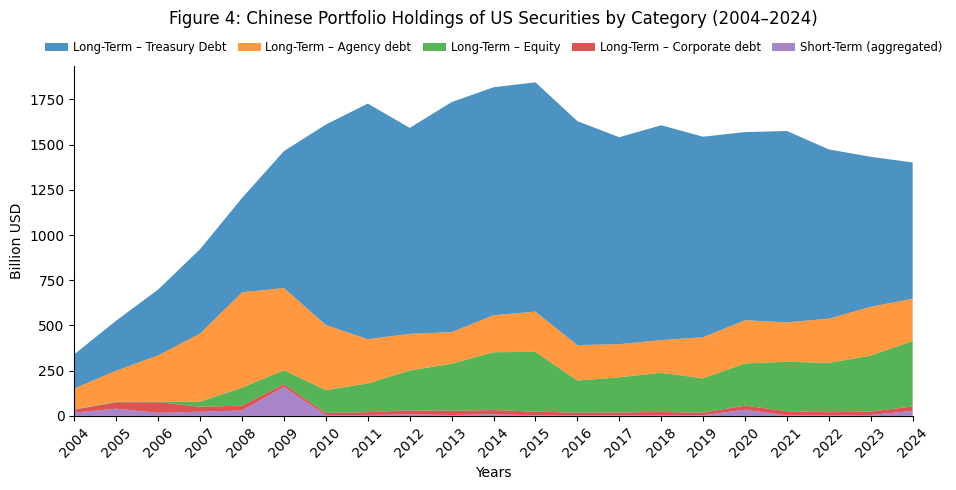

In [76]:
# Redact totals
plot_df = ticdata[
    ~ticdata["Category"].str.contains("Total", case=False, na=False) &
    ~ticdata["Position"].str.contains("Total", case=False, na=False)
].copy()

# Get Years
plot_df["Year"] = plot_df["Date"].dt.year

# Pivot by category
long_pivot = (plot_df[plot_df["Category"] == "Long-term"]
              .pivot_table(index="Year", columns="Position", values="Billion USD", aggfunc="sum")
              .fillna(0)
              .sort_index())

short_pivot = (plot_df[plot_df["Category"] == "Short-term"]
               .pivot_table(index="Year", columns="Position", values="Billion USD", aggfunc="sum")
               .fillna(0)
               .sort_index())

# Rename columns
long_pivot.columns = [f"Long-Term – {c}" for c in long_pivot.columns]

# Aggregate Short-Term positions into one column
short_aggregated = short_pivot.sum(axis=1).to_frame(name="Short-Term (aggregated)")

# Combine data
combined = pd.concat([long_pivot, short_aggregated], axis=1)
combined = combined[combined.sum().sort_values().index]

# Labels
labels = combined.columns.tolist()

# Get default colors and reverse
default_colors = [d["color"] for d in plt.rcParams["axes.prop_cycle"]]
while len(default_colors) < len(labels):
    default_colors += default_colors
colors_reversed = default_colors[:len(labels)][::-1]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(combined.index, combined.T, labels=labels, colors=colors_reversed, alpha=0.8)

# Axes styling
ax.set_title("Figure 4: Chinese Portfolio Holdings of US Securities by Category (2004–2024)", pad=30)
ax.set_xlabel("Years")
ax.set_ylabel("Billion USD")
ax.set_xticks(combined.index)
ax.set_xticklabels(combined.index.astype(int), rotation=45)
ax.set_xlim(combined.index.min(), combined.index.max())

# Legend directly below the title, horizontal
handles, labs = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labs[::-1],
                   loc='upper center',
                   bbox_to_anchor=(0.5, 1.10), 
                   fontsize='small',
                   frameon=False,
                   ncol=len(labels),               
                   columnspacing=1.0, 
                   handletextpad=0.4)   
legend.get_title().set_fontsize('medium')
# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

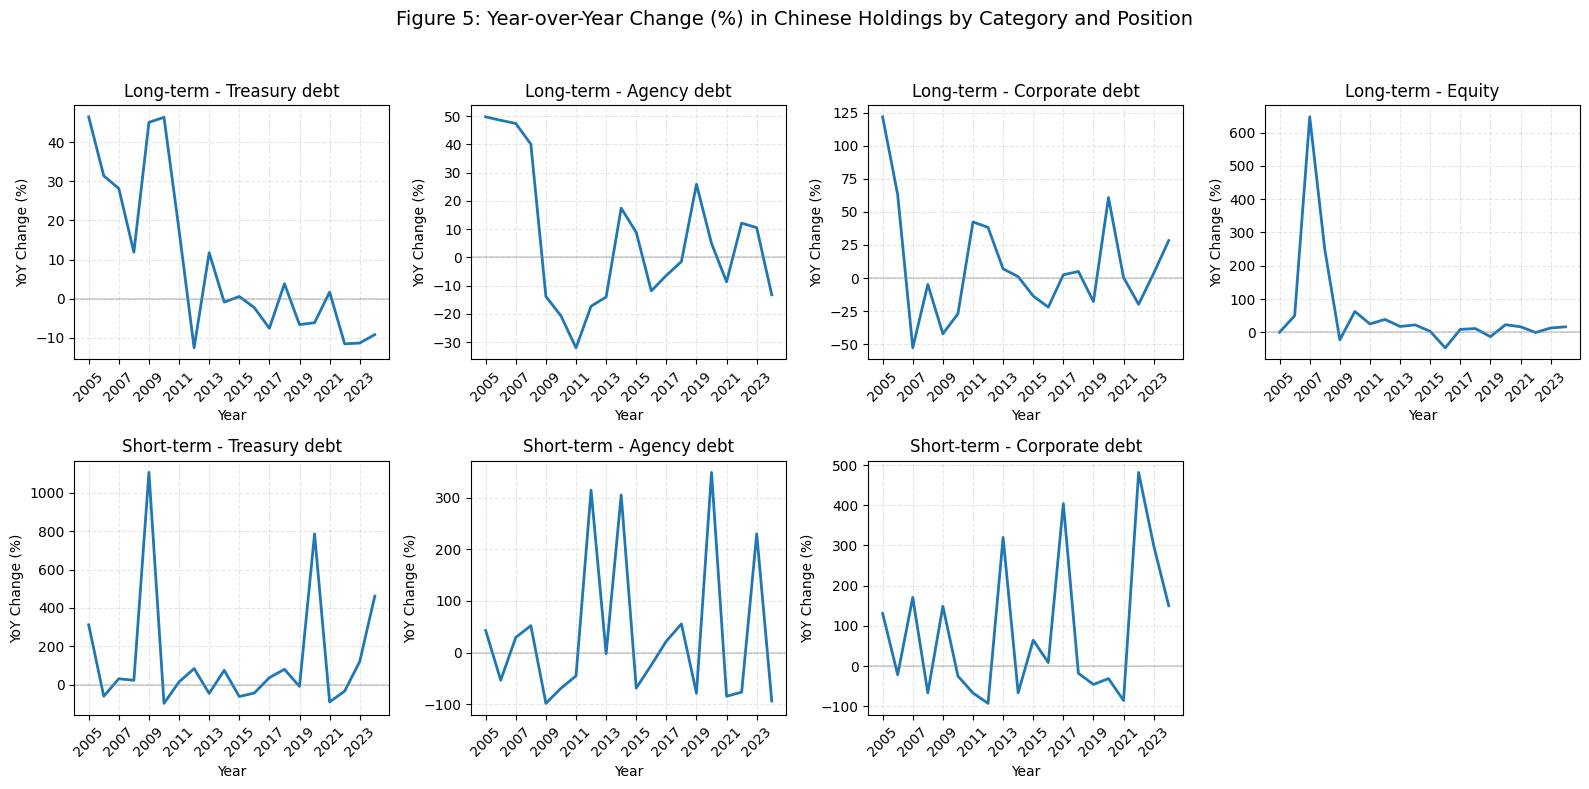

In [96]:
# Create dedicated DataFrame for facet wrap plot
df_facet_wrap = ticdata[
    ~ticdata["Category"].str.contains("Total", case=False, na=False) &
    ~ticdata["Position"].str.contains("Total", case=False, na=False)
].copy()

# Standardize Position names to avoid duplicates
df_facet_wrap["Position"] = df_facet_wrap["Position"].str.replace("Treasury Debt", "Treasury debt")

# Extract year from date
df_facet_wrap["Year"] = df_facet_wrap["Date"].dt.year

# Define positions to include in each category in the specified order
position_mapping = {
    "Long-term": ["Treasury debt", "Agency debt", "Corporate debt", "Equity"],
    "Short-term": ["Treasury debt", "Agency debt", "Corporate debt"]  # Removed Equity
}

# Calculate YoY changes for all combinations
yoy_data = {}
for category in ["Long-term", "Short-term"]:
    category_data = df_facet_wrap[df_facet_wrap["Category"] == category]
    for position in position_mapping[category]:
        position_data = category_data[category_data["Position"] == position]
        if not position_data.empty:
            # Group by year and sum values
            yearly_data = position_data.groupby("Year")["Billion USD"].sum()
            # Calculate YoY percentage change
            yoy_changes = yearly_data.pct_change() * 100
            # Store in our dictionary
            key = f"{category} - {position}"
            yoy_data[key] = yoy_changes.dropna()

# Create a grid of subplots - one for each category-position combination
n_cols = max(len(position_mapping["Long-term"]), len(position_mapping["Short-term"]))
fig, axes = plt.subplots(2, n_cols, figsize=(16, 8))

# Function to plot data with individual y-axis scaling
def plot_yoy_data(data, ax, title):
    if data.empty:
        ax.axis('off')
        return
        
    ax.plot(data.index, data.values, color='#1f77b4', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("YoY Change (%)")
    
    # Add zero line
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    # Set x-ticks to show years clearly
    ax.set_xticks(data.index[::2])  # Show every other year for cleaner display
    ax.set_xticklabels([str(y) for y in data.index[::2]], rotation=45)
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.3)

# Plot Long-term positions (top row)
for i, position in enumerate(position_mapping["Long-term"]):
    key = f"Long-term - {position}"
    if key in yoy_data:
        plot_yoy_data(yoy_data[key], axes[0, i], key)
    else:
        axes[0, i].axis('off')

# Plot Short-term positions (bottom row)
for i, position in enumerate(position_mapping["Short-term"]):
    key = f"Short-term - {position}"
    if key in yoy_data:
        plot_yoy_data(yoy_data[key], axes[1, i], key)
    else:
        axes[1, i].axis('off')

# Turn off any unused subplots
for i in range(len(position_mapping["Short-term"]), n_cols):
    axes[1, i].axis('off')

# Add title and adjust layout
plt.suptitle("Figure 5: Year-over-Year Change (%) in Chinese Holdings by Category and Position", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()